**Introduction:**

Heart disease is a prevalent health risk and one of the single largest causes of death in the world. Understanding which predictors affect the diagnosis of heart disease is important for understanding how to prevent heart disease. This data set (processed Cleveland data) includes observations of the age, sex, and results of many medical tests for people with and without heart disease.

The predictor variables we are interested in for this project are:
age - age of the patient in years
chol - serum cholesterol of the patient in mg/dl
thalach - maximum heart rate achieved in bpm
oldpeak - ST depression induced by exercise relative to rest
ca - number of major vessels (0-3) coloured by flourosopy
We are interested in these predictors because they are influential on the diagnosis of heart disease and they are numeric values, meaning we will be able to make a scatterplot with them to use in a k-nn classification model.

The target variable we are interested in predicting is “num”. This dataset only concentrates on whether heart disease is present (values 1,2,3,4) or absent (value 0). Therefore, we have coded all non zero values as a positive diagnosis and zero as a negative diagnosis for heart disease.

**Research question: Based on the age, chol, thalach, oldpeak, and ca variables for a patient, can we accurately predict whether or not they will receive a heart disease diagnosis.**


In [284]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(cowplot)

In [300]:
set.seed(9999)

In [301]:
# Loaded data set and omitted N/A values

url <- "https://archive.ics.uci.edu/static/public/45/data.csv"
heart <-  read_csv(url)
heart <- na.omit(heart)
head(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [302]:
# In the Cleveland dataset, any occurance of "num" other than 0 is considered a presence of heart disease
heart$num <- ifelse(heart$num >= 1 & heart$num <= 4, "yes", "no")

# Making num a factor variable
heart <- heart |>
        mutate(num = as_factor(num))
head(heart)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,no
67,1,4,160,286,0,2,108,1,1.5,2,3,3,yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3,no
56,1,2,120,236,0,0,178,0,0.8,1,0,3,no


In [303]:
# Separating data into training and testing sets
heart_split <- initial_split(heart, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [304]:
# Seeing number of occurances of each class of our target variable "num"
distribution <- heart_training |>
                group_by(num) |>
                summarize(count = n())
distribution

num,count
<fct>,<int>
no,120
yes,102


In [305]:
# Making a table of means of each predictor, based on diagnosis

mean_chol <- heart_training |>
            group_by(num) |>
            summarize(chol = mean(chol))
mean_age <- heart_training |>
            group_by(num) |>
            summarize(age = mean(age))
mean_thalach <- heart_training |>
                group_by(num) |>
                summarize(thalach = mean(thalach))
mean_oldpeak <- heart_training |>
                group_by(num) |>
                summarize(oldpeak = mean(oldpeak))
mean_ca <- heart_training |>
                group_by(num) |>
                summarize(ca = mean(ca))


combined_means <- bind_rows(mean_chol, mean_age, mean_thalach, mean_oldpeak, mean_ca) |>
                    pivot_longer(cols = chol:ca,
                                names_to = "predictor_name",
                                values_to = "predictor_mean") |>
                    na.omit() |>
                    rename("heart_disease" = "num")
combined_means

heart_disease,predictor_name,predictor_mean
<fct>,<chr>,<dbl>
no,chol,242.9250000
yes,chol,254.0686275
no,age,52.2166667
yes,age,57.6372549
no,thalach,158.0750000
yes,thalach,138.8627451
no,oldpeak,0.6233333
yes,oldpeak,1.7058824
no,ca,0.3166667


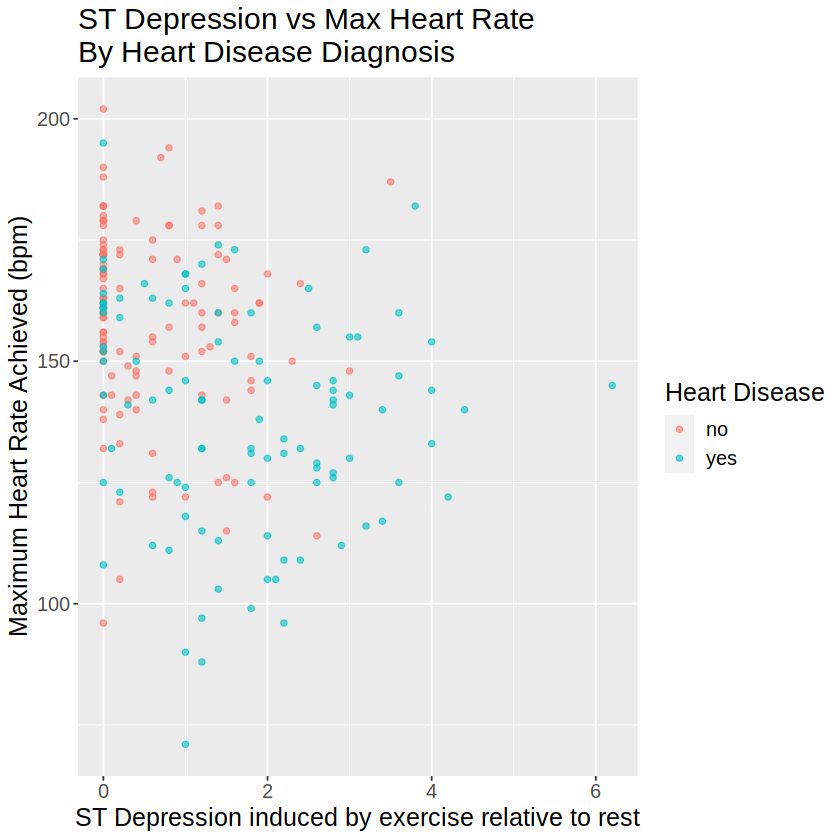

In [312]:
# Plotting cholesterol levels vs maximum heart rate achieved

# Converting "num" to a factor
heart_training$num <- as.factor(heart_training$num)

chol_vs_heart <- heart_training |>
    ggplot(aes(x = oldpeak, y = thalach, color = num)) +
    geom_point(alpha = 0.6) +
    labs(x = "ST Depression induced by exercise relative to rest",
         y = "Maximum Heart Rate Achieved (bpm)", color = "Heart Disease") +
    theme(text = element_text(size = 15)) +
    ggtitle("ST Depression vs Max Heart Rate\nBy Heart Disease Diagnosis")

chol_vs_heart


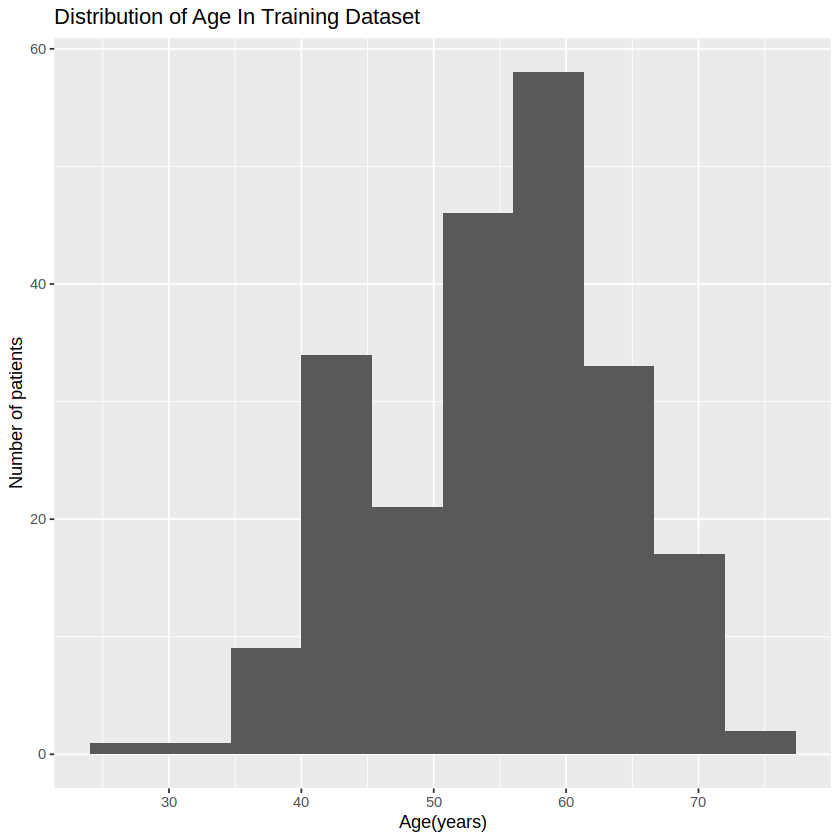

In [307]:
agedistribution <- heart_training |>
ggplot(aes(x = age)) +
geom_histogram(bins = 10) +
labs(x = "Age(years)", y = "Number of patients") +
ggtitle("Distribution of Age In Training Dataset")
agedistribution

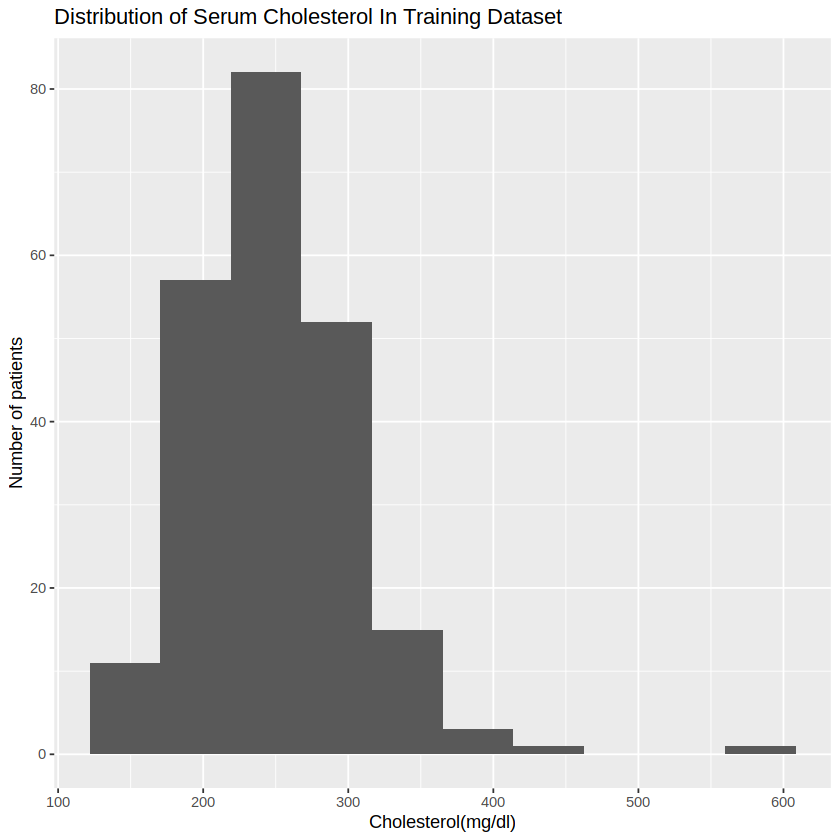

In [308]:
choldistribution <- heart_training |>
ggplot(aes(x = chol)) +
geom_histogram(bins = 10) +
labs(x = "Cholesterol(mg/dl)", y = "Number of patients") +
ggtitle("Distribution of Serum Cholesterol In Training Dataset")
choldistribution

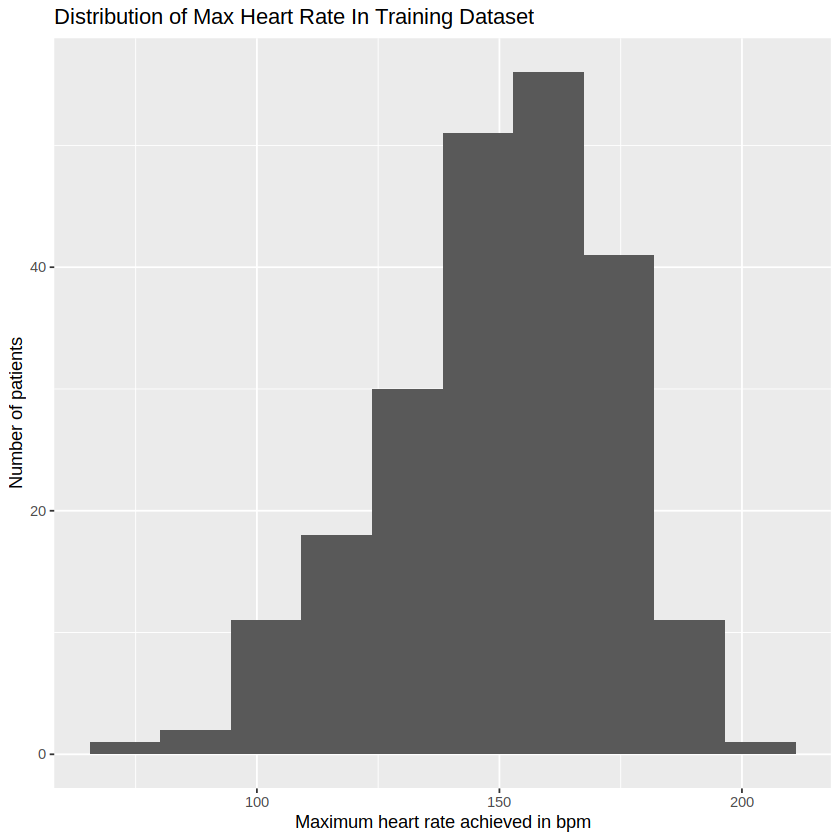

In [309]:
thalachdistribution <- heart_training |>
ggplot(aes(x = thalach)) +
geom_histogram(bins = 10) +
labs(x = "Maximum heart rate achieved in bpm", y = "Number of patients") +
ggtitle("Distribution of Max Heart Rate In Training Dataset")
thalachdistribution

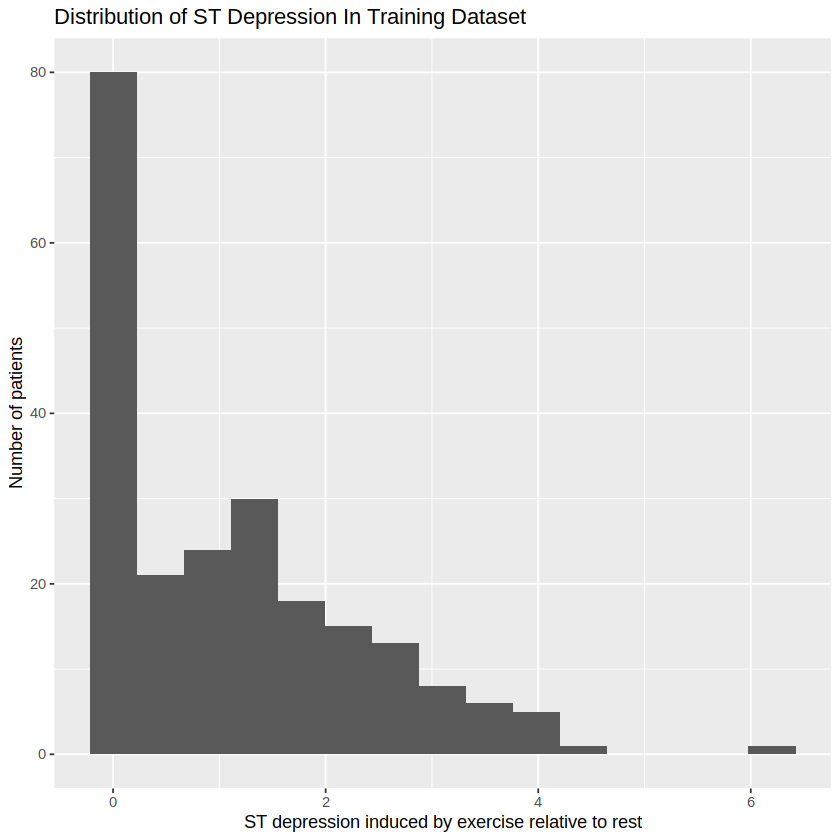

In [310]:
oldpeakdistribution <- heart_training |>
ggplot(aes(x = oldpeak)) +
geom_histogram(bins = 15) +
labs(x = "ST depression induced by exercise relative to rest", y = "Number of patients") +
ggtitle("Distribution of ST Depression In Training Dataset")
oldpeakdistribution


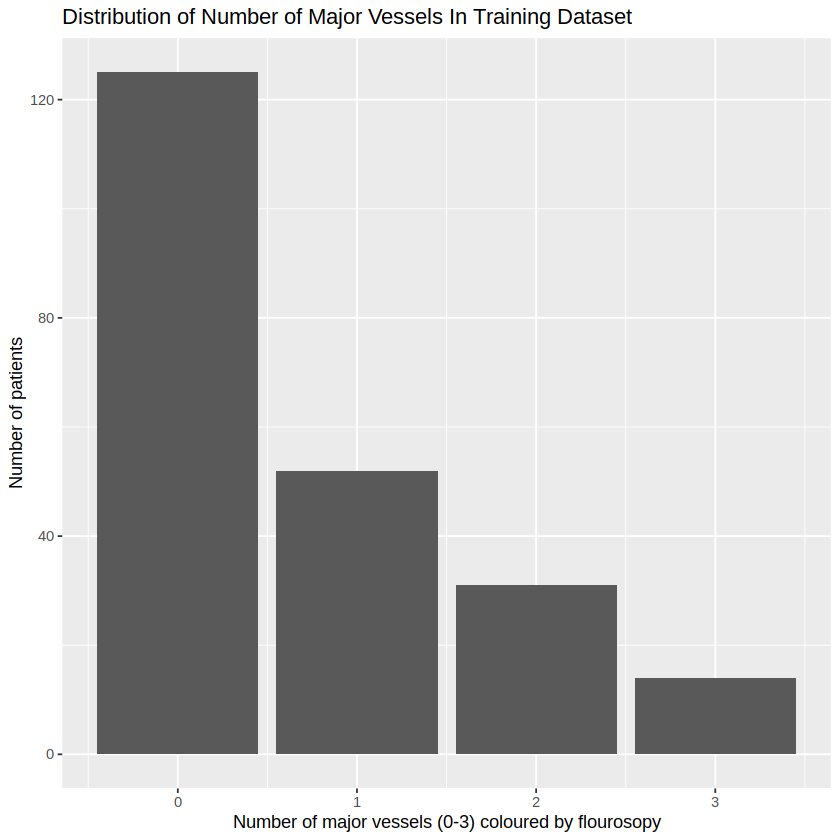

In [311]:
cadistribution <- heart_training |>
ggplot(aes(x = ca)) +
geom_bar() +
labs(x = "Number of major vessels (0-3) coloured by flourosopy", y = "Number of patients") +
ggtitle("Distribution of Number of Major Vessels In Training Dataset")
cadistribution

**Method**

We will make a k-nn classification model to predict whether or not a person will have a diagnosis of heart 
disease based on these predictor variables: age, chol, thalach, oldpeak, and ca. We will tune our classifier by
cross-validating our data to determine the K-value that will give us the best accuracy, then make a new
classification model using this K-value.

We will visualize the results by making scatterplots for each combination of two variables with a legend that 
will color the point based on whether or not they have a heart disease diagnosis. We will add color to the 
“background” of the graph showing the areas where an observation would be predicted to have a heart disease 
diagnosis and to not have a heart disease diagnosis.


**What do you expect to find?**

We want to find which variables will cause the diagnosis of heart disease. We expect that older age, higher cholesterol, higher ST depression induced by exercise, and higher number of major vessels coloured by fluoroscopy will be correlated with a diagnosis of heart disease, and that a lower maximum heart rate achieved will be correlated with a diagnosis of heart disease.

**What impact could such findings have?**

Our model will help us identify which patients are predicted to be having heart disease. Using this information, we can identify patients who needs immediate medical attention to prevent potentially life threatening situations like a heart attack from occurring. Preventive measures can be performed by a doctor upon this predictive diagnosis. This could possibly save a patient's life. 

**What future questions could this lead to?**

- What are the specific clinical scenarios or patient populations for which the model is most beneficial?
- Why is a certain variable correlated with a positive heart disease diagnosis? 
- How can we use these findings to prevent heart disease?
- How can we use data analysis to predict those who are at risk for heart disease?
- How can the quality and quantity of data used for model development be improved to enhance prediction accuracy?